In [1]:
%run data_loader.py

Data loaded


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow import keras as K
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.__version__

'2.12.0'

# Loading and studying data

In [4]:
train = pd.read_csv("data/train_labels.csv", dtype=str)
print(train.shape)

(220025, 2)


In [5]:
train.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
train["id"] = train.id+".tif"

In [7]:
train.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [8]:
y_train = train.label

(train.label.value_counts() / len(train)).to_frame().T

label,0,1
count,0.594969,0.405031


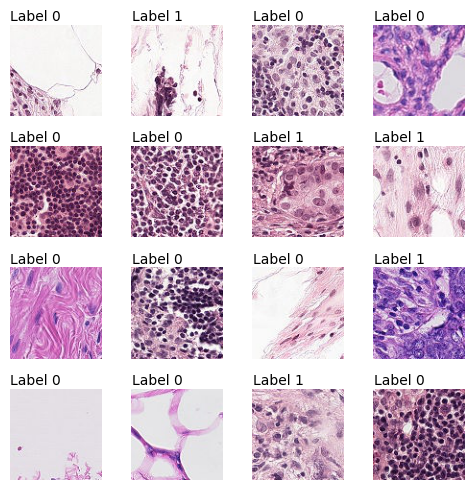

In [9]:
plt.figure(figsize=(5,5)) 

for i in range(16):
    plt.subplot(4,4,i+1)   
    img = mpimg.imread(f'data/train/{train["id"][i]}')
    plt.imshow(img)
    plt.text(0, -5, f'Label {train["label"][i]}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [10]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=45, stratify=train.label)

print(train_df.shape)
print(valid_df.shape)

(176020, 2)
(44005, 2)


In [11]:
BATCH_SIZE = 64
image_generator = ImageDataGenerator(rescale=1/255)

train_loader = image_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = 'data/train/',
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32,32)
)

valid_loader = image_generator.flow_from_dataframe(
    dataframe = valid_df,
    directory = 'data/train/',
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32,32)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [12]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)

print(TR_STEPS)
print(VA_STEPS)

2751
688


# Build the network

In [13]:
base_model = tf.keras.applications.VGG16(input_shape=(32,32,3),
                                         include_top=False,
                                         weights='imagenet')

base_model.trainable = False

In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [15]:
cnn = Sequential([
    base_model, 
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(16, activation="relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(8, activation="relu"),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2,activation="sigmoid")
    ])

In [16]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [17]:
%%time 

h1 = cnn.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 15,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

Epoch 1/15
2751/2751 [==============================] - 460s 167ms/step - loss: 0.5689 - accuracy: 0.7031 - auc: 0.7751 - val_loss: 0.4854 - val_accuracy: 0.7746 - val_auc: 0.8539
Epoch 2/15
2751/2751 [==============================] - 484s 176ms/step - loss: 0.5156 - accuracy: 0.7583 - auc: 0.8257 - val_loss: 0.4853 - val_accuracy: 0.7609 - val_auc: 0.8504
Epoch 3/15
2751/2751 [==============================] - 470s 171ms/step - loss: 0.5049 - accuracy: 0.7644 - auc: 0.8340 - val_loss: 0.4598 - val_accuracy: 0.7855 - val_auc: 0.8659
Epoch 4/15
2751/2751 [==============================] - 461s 167ms/step - loss: 0.4970 - accuracy: 0.7696 - auc: 0.8402 - val_loss: 0.4679 - val_accuracy: 0.7730 - val_auc: 0.8617
Epoch 5/15
2751/2751 [==============================] - 458s 166ms/step - loss: 0.4929 - accuracy: 0.7700 - auc: 0.8435 - val_loss: 0.4531 - val_accuracy: 0.7872 - val_auc: 0.8718
Epoch 6/15
2751/2751 [==============================] - 477s 173ms/step - loss: 0.4881 - accuracy: 0

In [18]:
history4 = h1.history
print(history4.keys())

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])


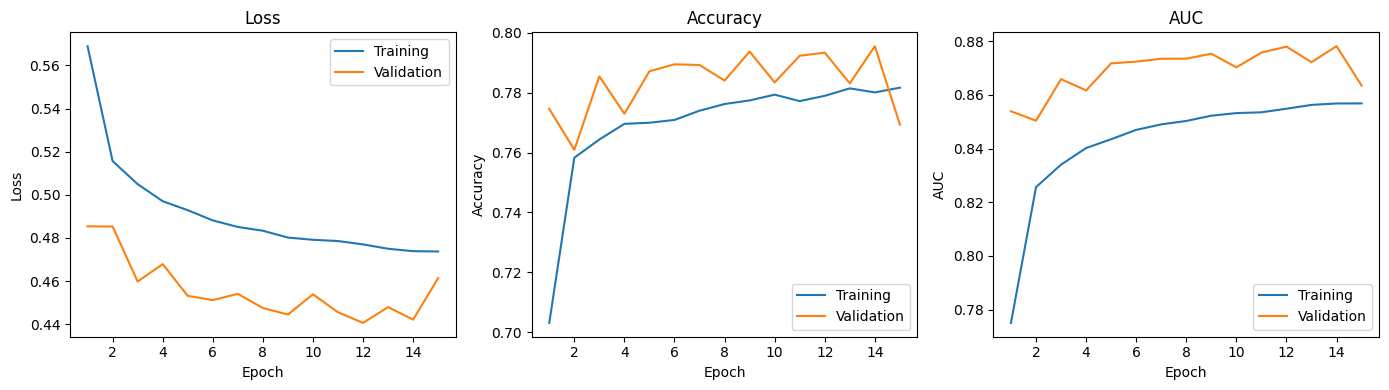

In [19]:
epoch_range = range(1, len(history4['loss'])+1)

plt.figure(figsize=[14,4])

plt.subplot(1,3,1)
plt.plot(epoch_range, history4['loss'], label='Training')
plt.plot(epoch_range, history4['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epoch_range, history4['accuracy'], label='Training')
plt.plot(epoch_range, history4['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epoch_range, history4['auc'], label='Training')
plt.plot(epoch_range, history4['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Second model

In [20]:
cnn2 = Sequential([
    base_model, 
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.75),
    Dense(16, activation="relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(8, activation="relu"),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2,activation="sigmoid")
    ])

opt = tf.keras.optimizers.Adagrad(learning_rate=0.98)
cnn2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

h2 = cnn2.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 15,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)


Epoch 1/15
2751/2751 [==============================] - 471s 171ms/step - loss: 0.6538 - accuracy: 0.6093 - auc_1: 0.6517 - val_loss: 0.6189 - val_accuracy: 0.5950 - val_auc_1: 0.7228
Epoch 2/15
2751/2751 [==============================] - 482s 175ms/step - loss: 0.6204 - accuracy: 0.6343 - auc_1: 0.7043 - val_loss: 0.5542 - val_accuracy: 0.7378 - val_auc_1: 0.8064
Epoch 3/15
2751/2751 [==============================] - 460s 167ms/step - loss: 0.6041 - accuracy: 0.6610 - auc_1: 0.7312 - val_loss: 0.6170 - val_accuracy: 0.5950 - val_auc_1: 0.7439
Epoch 4/15
2751/2751 [==============================] - 460s 167ms/step - loss: 0.5960 - accuracy: 0.6728 - auc_1: 0.7427 - val_loss: 0.5475 - val_accuracy: 0.7535 - val_auc_1: 0.8149
Epoch 5/15
2751/2751 [==============================] - 464s 169ms/step - loss: 0.5910 - accuracy: 0.6788 - auc_1: 0.7489 - val_loss: 0.5649 - val_accuracy: 0.5950 - val_auc_1: 0.7465
Epoch 6/15
2751/2751 [==============================] - 462s 168ms/step - loss: 

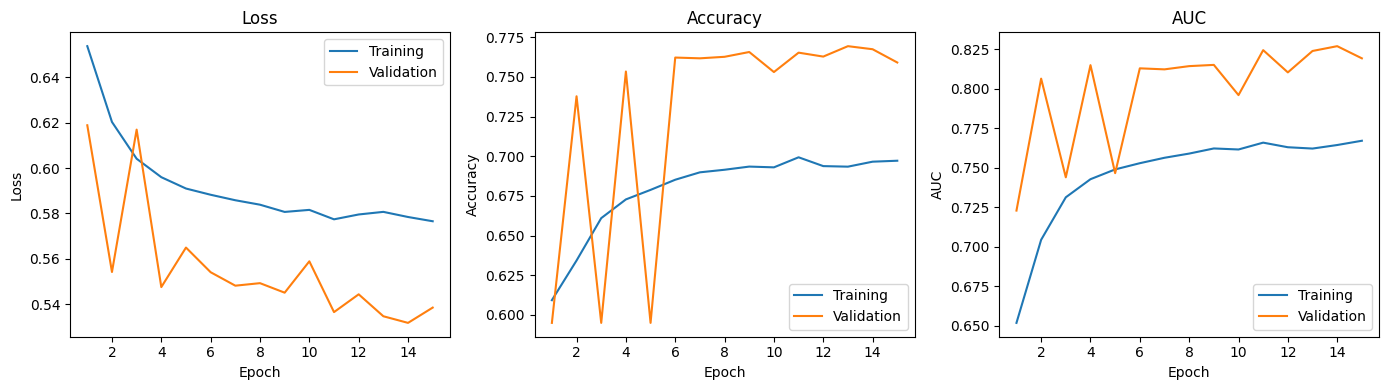

In [21]:
history4 = h2.history

epoch_range = range(1, len(history4['loss'])+1)

plt.figure(figsize=[14,4])

plt.subplot(1,3,1)
plt.plot(epoch_range, history4['loss'], label='Training')
plt.plot(epoch_range, history4['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epoch_range, history4['accuracy'], label='Training')
plt.plot(epoch_range, history4['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epoch_range, history4['auc_1'], label='Training')
plt.plot(epoch_range, history4['val_auc_1'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
print(history4.keys())

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])


In [23]:
layers = base_model.layers
new_model_layers = layers[:-4]
new_model = tf.keras.models.Model(inputs=base_model.input, outputs=new_model_layers[-1].output)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [24]:
cnn3 = Sequential([
    new_model,
    Conv2D(filters=512,kernel_size=(1,1)),
    Conv2D(filters=512,kernel_size=(1,1),activation="relu"),
    MaxPool2D(pool_size=(1,1)),
    Conv2D(filters=256,kernel_size=(1,1),activation="relu"),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(16, activation="relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(8, activation="relu"),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2,activation="tanh")
    ])
opt = tf.keras.optimizers.Adagrad(learning_rate=0.4)
cnn3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

h3 = cnn3.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 30,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)
history3 = h3.history
print(history3.keys())

Epoch 1/30
2751/2751 [==============================] - 436s 158ms/step - loss: 0.6851 - accuracy: 0.5862 - auc_2: 0.6282 - val_loss: 0.6398 - val_accuracy: 0.5950 - val_auc_2: 0.6592
Epoch 2/30
2751/2751 [==============================] - 433s 157ms/step - loss: 0.6559 - accuracy: 0.6087 - auc_2: 0.6540 - val_loss: 0.6751 - val_accuracy: 0.5950 - val_auc_2: 0.5887
Epoch 3/30
2751/2751 [==============================] - 450s 164ms/step - loss: 0.6752 - accuracy: 0.5950 - auc_2: 0.5969 - val_loss: 0.6754 - val_accuracy: 0.5950 - val_auc_2: 0.6006
Epoch 4/30
2751/2751 [==============================] - 438s 159ms/step - loss: 0.6752 - accuracy: 0.5950 - auc_2: 0.5964 - val_loss: 0.6750 - val_accuracy: 0.5950 - val_auc_2: 0.5951
Epoch 5/30
2751/2751 [==============================] - 460s 167ms/step - loss: 0.6750 - accuracy: 0.5950 - auc_2: 0.5967 - val_loss: 0.6751 - val_accuracy: 0.5950 - val_auc_2: 0.5950
Epoch 6/30
2751/2751 [==============================] - 457s 166ms/step - loss: 

In [25]:
cnn4 = Sequential([
    new_model,
    Conv2D(filters=512,kernel_size=(1,1)),
    Conv2D(filters=512,kernel_size=(1,1),activation="relu"),
    MaxPool2D(pool_size=(1,1)),
    Conv2D(filters=256,kernel_size=(1,1),activation="relu"),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(16, activation="relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(8, activation="relu"),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2,activation="softmax")
    ])
opt = tf.keras.optimizers.Adadelta(learning_rate=0.46)
cnn4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

h4 = cnn4.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 15,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)
history4 = h4.history
print(history4.keys())

Epoch 1/15
2751/2751 [==============================] - 447s 162ms/step - loss: 0.5197 - accuracy: 0.7485 - auc_3: 0.8219 - val_loss: 0.4359 - val_accuracy: 0.8063 - val_auc_3: 0.8867
Epoch 2/15
2751/2751 [==============================] - 446s 162ms/step - loss: 0.4608 - accuracy: 0.7945 - auc_3: 0.8660 - val_loss: 0.4264 - val_accuracy: 0.8013 - val_auc_3: 0.8876
Epoch 3/15
2751/2751 [==============================] - 444s 162ms/step - loss: 0.4463 - accuracy: 0.8044 - auc_3: 0.8760 - val_loss: 0.4614 - val_accuracy: 0.7774 - val_auc_3: 0.8622
Epoch 4/15
2751/2751 [==============================] - 449s 163ms/step - loss: 0.4332 - accuracy: 0.8115 - auc_3: 0.8829 - val_loss: 0.4156 - val_accuracy: 0.8120 - val_auc_3: 0.8936
Epoch 5/15
2751/2751 [==============================] - 450s 164ms/step - loss: 0.4225 - accuracy: 0.8165 - auc_3: 0.8895 - val_loss: 0.4098 - val_accuracy: 0.8139 - val_auc_3: 0.8949
Epoch 6/15
2751/2751 [==============================] - 445s 162ms/step - loss: 

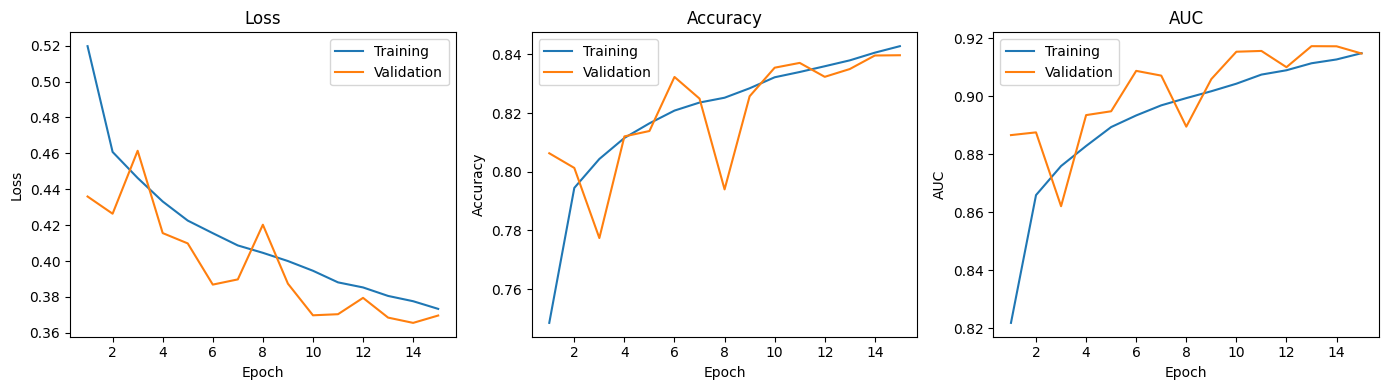

In [28]:
history4 = h4.history

epoch_range = range(1, len(history4['loss'])+1)

plt.figure(figsize=[14,4])

plt.subplot(1,3,1)
plt.plot(epoch_range, history4['loss'], label='Training')
plt.plot(epoch_range, history4['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(epoch_range, history4['accuracy'], label='Training')
plt.plot(epoch_range, history4['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

plt.subplot(1,3,3)
plt.plot(epoch_range, history4['auc_3'], label='Training')
plt.plot(epoch_range, history4['val_auc_3'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# Save Model and History

In [29]:
cnn4.save('cancer_model_v01.h5')
pickle.dump(history4, open(f'cancer_history_v01.pkl', 'wb'))